In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
#from scipy.ndimage import gaussian_filter1d
import sys

In [2]:
date = '20220603'
data_name = 'Raman1H_beam_shape.tiff'

path_img = r"./"+date

share = Path(path_img)
if share.exists():
    beam_mode_files = list(Path(path_img).glob(data_name))
else:
    print("No image")

In [3]:
img_beam_mode_list = []
for N in range(len(beam_mode_files)):
    img_beam_mode_list.append(np.array(Image.open(beam_mode_files[N])))

In [4]:
sample_img = img_beam_mode_list[0]

In [5]:
magnification = 1.369
CCD_pixel_size = 6.45 #[um]
binning = 2
d = CCD_pixel_size*binning/magnification

In [6]:
pos_x=np.linspace(0, d*(np.shape(sample_img)[1]-1), np.shape(sample_img)[1])
pos_y=np.linspace(0, d*(np.shape(sample_img)[0]-1), np.shape(sample_img)[0])
mesh_x, mesh_y =np.meshgrid(pos_x,pos_y)

fitParameter_0=1.0970839672305874e-06(1.646373096687469e-09)
fitParameter_1=3043.1373983691287(0.33056462674434994)
fitParameter_2=381.5090848811211(0.6766469771637537)
fitParameter_3=0.001193375905580709(1.000766811567407e-06)


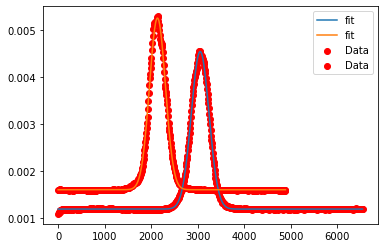

In [8]:
# x_list =np.arange(np.shape(sample_img)[1])
# x_list_2 =np.arange(np.shape(sample_img)[0])
x_list = pos_x
x_list_2 = pos_y
nx=np.sum(sample_img, axis=0)/np.sum(sample_img)
ny=np.sum(sample_img, axis=1)/np.sum(sample_img)
CoMy = []
CoMx = []

for i in range(len(nx)):
    CoMx += [i*nx[i]]
for i in range(len(ny)):
    CoMy += [i*ny[i]]
CoMx = np.sum(CoMx)
CoMy = np.sum(CoMy)

def gaussian_1d(x,*fit_param):
    return fit_param[0]*x*np.exp(-2*(x-fit_param[1])**2/fit_param[2]**2)+fit_param[3]

def fit_result(fit_func, x_data_list, y_data_list, initial_param_list, yerr=None):
    if (yerr is None):
        param, cov = scipy.optimize.curve_fit(fit_func, x_data_list, y_data_list, p0 = initial_param_list)
    else:
        param, cov = scipy.optimize.curve_fit(fit_func, x_data_list, y_data_list, p0 = initial_param_list, sigma=yerr)
    perr = np.sqrt(np.diag(cov))
    x_fit_list = np.linspace(np.min(x_data_list),np.max(x_data_list),400)
    y_fit_list = []
    for num in x_fit_list:
        y_fit_list.append(fit_func(num, *param))
    return param, perr, x_fit_list, y_fit_list

# para_ini=[np.max(nx), 170, 10, np.mean(nx[0:5])]
para_ini=[np.max(nx), 3000, 200, np.mean(nx[0:5])]
fitResultsOfSampleImage_list = fit_result(gaussian_1d, x_list, nx, para_ini)

for i in range(len(para_ini)):
    print("fitParameter_"+str(i)+"="+str(fitResultsOfSampleImage_list[0][i])+"("+str(fitResultsOfSampleImage_list[1][i])+")")

# para_ini=[np.max(nx), 130, 10, np.mean(nx[0:5])]
para_ini=[np.max(ny), 2000, 200, np.mean(ny[0:5])]
fitResultsOfSampleImage_list_2 = fit_result(gaussian_1d, x_list_2, ny, para_ini)

plt.scatter(x_list,nx, label='Data',c="r")
plt.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],label="fit")
plt.legend()

plt.scatter(x_list_2,ny, label='Data',c="r")
plt.plot(fitResultsOfSampleImage_list_2[2],fitResultsOfSampleImage_list_2[3],label="fit")
plt.legend()

In [9]:
w0_x = fitResultsOfSampleImage_list[0][2]
print("w0_x = %.03f [um]"%(w0_x))

w0_y = fitResultsOfSampleImage_list_2[0][2]
print("w0_y = %.03f [um]"%(w0_y))

w0_x = 381.509 [um]
w0_y = 343.602 [um]


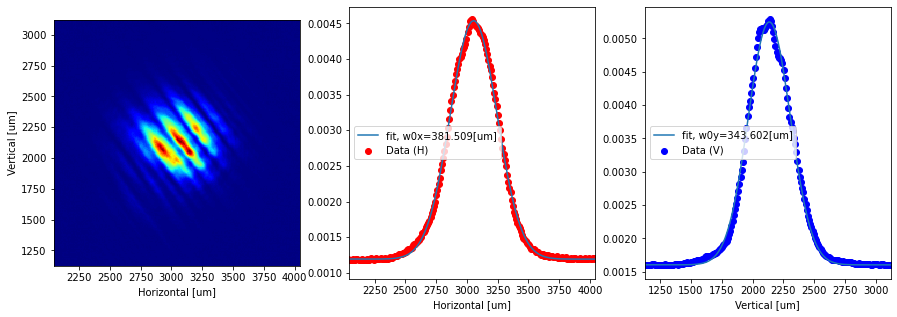

In [11]:
vmin = np.min(sample_img)
vmax = np.max(sample_img)
roi_x_width = 1000
roi_y_width = 1000
roi_x_center = fitResultsOfSampleImage_list[0][1]
roi_y_center = fitResultsOfSampleImage_list_2[0][1]
xlim_1 = roi_x_center - roi_x_width  
xlim_2 = roi_x_center + roi_x_width
ylim_1 = roi_y_center - roi_y_width
ylim_2 = roi_y_center + roi_y_width

fig =plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(1,3,1)
mappable =ax1.pcolormesh(mesh_x,mesh_y,sample_img, vmin=vmin, vmax=vmax, shading='auto',cmap = 'jet')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_xlabel('Horizontal [um]')
ax1.set_ylabel('Vertical [um]')

ax2 = fig.add_subplot(1,3,2)
ax2.scatter(x_list,nx, label='Data (H)',c="r")
ax2.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],label="fit, w0x=%.03f[um]"%(w0_x))
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_xlabel('Horizontal [um]')
ax2.legend()

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(x_list_2,ny, label='Data (V)',c="b")
ax3.plot(fitResultsOfSampleImage_list_2[2],fitResultsOfSampleImage_list_2[3],label="fit, w0y=%.03f[um]"%(w0_y))
ax3.set_xlim(ylim_1,ylim_2)
ax3.set_xlabel('Vertical [um]')
ax3.legend()